In [2]:
import os

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import shapely.geometry
from scipy.misc import imresize

%matplotlib inline

In [ ]:
with open('mn_xtrain_256_bgr_man.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('mn_ytrain_256_man.pkl', 'rb') as f:
    Y_train = pickle.load(f)

with open('mn_xval_256_bgr_man.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open('mn_yval_256_man.pkl', 'rb') as f:
    Y_val = pickle.load(f)

In [5]:
# Load the image summary
image_summary = gpd.read_file('vectors/shanghai_RGB_image_summary.geojson')

# Load the landuse data from OSM
osm_landuse = gpd.read_file('vectors/shanghai_landuse.geojson')
osm_leisure = gpd.read_file('vectors/shanghai_leisure_RGB.geojson')

# Convert everything to polygons
osm_landuse.set_geometry(osm_landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)
osm_leisure.set_geometry(osm_leisure.geometry.apply(shapely.geometry.Polygon), inplace=True)

# Limit to just farmland
farmland = osm_landuse[osm_landuse.landuse == 'farmland'].unary_union

# Background
farmyard = osm_landuse[osm_landuse.landuse == 'farmyard'].unary_union
industrial = osm_landuse[osm_landuse.landuse == 'industrial'].unary_union
park = osm_leisure[osm_leisure.leisure == 'park'].unary_union

vectors = [farmland]

In [6]:
INPUT_SIZE = 224

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []
    
def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def scale_bands(img, lower_pct=1, upper_pct=99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

# Build a training set
def make_set(image_summary, vectors, training_set_size, input_size, random=np.random):
    rows_to_use = random.choice(image_summary.index, training_set_size, replace=False)
    X = []
    Y = []
    X_val = []
    Y_val = []
    for i, row in image_summary.loc[rows_to_use].iterrows():
        with rasterio.open(row.image_name) as src:
            img = src.read().transpose([1, 2, 0])
            img = img[::-1]
            img_bounds = shapely.geometry.box(*src.bounds)
            img_transform = list(np.array(~src.transform)[[0, 1, 3, 4, 2, 5]])
        
        # Ignore faulty images
        faulty_imgs = []
        if np.sum(img==0) > 500:
            faulty_imgs.append(img)
        else:
           
            masks = []

            # farmland only...to remove farmyard

            for i, poly in enumerate(vectors):
                if i == 0:
                    mask_poly = poly.intersection(img_bounds)
                    mask_farmyard = farmyard.intersection(img_bounds)

                    # Transform it into pixel coordinates
                    mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)
                    mask_farmyard_pxcoords = shapely.affinity.affine_transform(mask_farmyard, img_transform)
                    mask_poly_pxcoords = mask_poly_pxcoords - mask_farmyard_pxcoords

                    # Convert the polygon into a mask
                    mask = make_mask(img.shape[:2], mask_poly_pxcoords)
                    mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))

                    masks.append(mask[..., None])
                else:
                    # Get the intersection between the polygon and the image bounds
                    mask_poly = poly.intersection(img_bounds)

                    # Transform it into pixel coordinates
                    mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

                    # Convert the polygon into a mask
                    mask = make_mask(img.shape[:2], mask_poly_pxcoords)
                    mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))

                    masks.append(mask[..., None])
            masks = np.concatenate(masks, axis=2)
            img = resize(img, (input_size, input_size))

            # Add each mask to a list
            # TODO: randomly generate starting position in x and y directions for crop
            X.append(img[None, ...])
            Y.append(masks[None, ...])
    
    for i, row in image_summary.iterrows():
        if i not in rows_to_use:
            with rasterio.open(row.image_name) as src:
                img = src.read().transpose([1, 2, 0])
                img = img[::-1]
                img_bounds = shapely.geometry.box(*src.bounds)
                img_transform = list(np.array(~src.transform)[[0, 1, 3, 4, 2, 5]])

            # Ignore faulty images
            if np.sum(img==0) < 500:

                masks = []

                for i, poly in enumerate(vectors):
                    #farmland only...to remove farmyard
                    if i == 0:
                        mask_poly = poly.intersection(img_bounds)
                        mask_farmyard = farmyard.intersection(img_bounds)

                        # Transform it into pixel coordinates
                        mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)
                        mask_farmyard_pxcoords = shapely.affinity.affine_transform(mask_farmyard, img_transform)
                        mask_poly_pxcoords = mask_poly_pxcoords - mask_farmyard_pxcoords

                        # Convert the polygon into a mask
                        mask = make_mask(img.shape[:2], mask_poly_pxcoords)
                        mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))

                        masks.append(mask[..., None])
                    else:
                        # Get the intersection between the polygon and the image bounds
                        mask_poly = poly.intersection(img_bounds)

                        # Transform it into pixel coordinates
                        mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

                        # Convert the polygon into a mask
                        mask = make_mask(img.shape[:2], mask_poly_pxcoords)
                        mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))

                        masks.append(mask[..., None])
                masks = np.concatenate(masks, axis=2)
                img = resize(img, (input_size, input_size))

                # Add each mask to a list
                # TODO: randomly generate starting position in x and y directions for crop
                X_val.append(img[None, ...])
                Y_val.append(masks[None, ...])
    # Concatenate the results
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    X_val = np.concatenate(X_val, axis=0)
    Y_val = np.concatenate(Y_val, axis=0)
    
    # Normalize the values
    X = X.astype('float32')
    X = (X / X.max() - 0.5) * 2 # put X in range [-1, 1]
    Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
    X_val = X_val.astype('float32')
    X_val = (X_val / X_val.max() - 0.5) * 2 # put X in range [-1, 1]
    Y_val = Y_val.astype('float32') / 255 # put Y in range [0, 1]
    
    return X, Y, X_val, Y_val

random = np.random.RandomState(2)
X_train, Y_train, X_val, Y_val = make_set(image_summary, vectors, 4000, INPUT_SIZE)
#X_val, Y_val = make_set(image_summary, vectors, 800, INPUT_SIZE, random)
    

610

In [22]:
X_train.shape[0]

3972

In [20]:
X_val.shape

(580, 224, 224, 3)

In [19]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras import applications
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Lambda, Add, Reshape, ZeroPadding2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
import keras.backend.tensorflow_backend
from keras.utils.data_utils import get_file

# Clear any junk from session memory
K.clear_session()

# Set network size params
N_CLASSES = 1
N_CHANNEL = 3
INPUT_SIZE = 224

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')


# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def mean_pixel_intersection_over_union(y_true, y_pred):
    tp = np.sum((y_pred > 0.15) & (y_true > 0.15))
    tn = np.sum((y_pred < 0.15) & (y_true < 0.15))
    fp = np.sum((y_pred > 0.15) & (y_true < 0.15))
    fn = np.sum((y_pred < 0.15) & (y_true > 0.15))
    return K.mean(tp/(tp+fp+fn))


def fcn_model(lr=.001):
    K.clear_session()
    
    img_input = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
        
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = Dropout(0.5)(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x = Dropout(0.5)(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(0.5)(pool3)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    x = Dropout(0.5)(pool4)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = Dropout(0.5)(pool5)

    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(pool5)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    drop = Dropout(0.5)(x)
    
    
    
    score_c5 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(drop)
    up_c5 = Conv2DTranspose(N_CLASSES, (2, 2), strides=(2, 2), padding='valid')(score_c5)
    
    score_c4 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(pool4)
    fuse_16 = Add()([score_c4, up_c5])
    up_c4 = Conv2DTranspose(N_CLASSES, (2, 2), strides=(2, 2), padding='valid')(fuse_16)
    
    score_c3 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(pool3)
    fuse_32 = Add()([score_c3, up_c4])
    up_c3 = Conv2DTranspose(N_CLASSES, (8, 8), strides=(8, 8), padding='valid', activation='sigmoid')(fuse_32)





    #fcn_model = Sequential()
    fcn_model = Model(inputs=img_input, outputs=up_c3)
    
    #fcn_model.load_weights(weights_path, by_name=True)
    fcn_model.load_weights(os.path.join('checkpoints_ffip_fcn_vgg', 'newFIXEDweights.00-0.06959.hdf5'), by_name=False)
    
    fcn_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef])
    
    return fcn_model











In [ ]:
lr = 0.001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
              patience=5, min_lr=0.0000000001)

if not os.path.exists('checkpoints_ffip_fcn_vgg'):
    os.makedirs('checkpoints_ffip_fcn_vgg')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints_ffip_fcn_vgg', 'newFIXEDweights.{epoch:02d}-{loss:.5f}.hdf5'),
                                  monitor='val_loss', save_best_only=True)


NUM_EPOCHS = 80
# gen = ImageDataGenerator()
# train_batches = gen.flow(X_train, Y_train)
# tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)
STEPS_PER_EPOCH = X_train.shape[0] / 32
VALIDATION_STEPS = len(X_val) / 32
#INPUT_SIZE = 256


model = fcn_model(lr=.0001)
#model.fit_generator(train_batches, steps_per_epoch=STEPS_PER_EPOCH, epochs=NUM_EPOCHS, verbose=1, callbacks=[reduce_lr])
model.fit(X_train, Y_train, batch_size=12, epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_data=(X_val, Y_val),
         callbacks=[model_checkpoint])


Train on 3616 samples, validate on 519 samples
Epoch 1/80
3616/3616 [==============================] - 527s - loss: 0.0735 - jacc_coef: 0.3108 - val_loss: 0.1076 - val_jacc_coef: 0.3210
Epoch 2/80
3616/3616 [==============================] - 522s - loss: 0.0710 - jacc_coef: 0.3344 - val_loss: 0.1249 - val_jacc_coef: 0.2895
Epoch 5/80
3616/3616 [==============================] - 522s - loss: 0.0685 - jacc_coef: 0.3229 - val_loss: 0.1125 - val_jacc_coef: 0.2612
Epoch 6/80
3616/3616 [==============================] - 524s - loss: 0.0678 - jacc_coef: 0.3312 - val_loss: 0.0978 - val_jacc_coef: 0.3122
Epoch 7/80
3616/3616 [==============================] - 522s - loss: 0.0678 - jacc_coef: 0.3274 - val_loss: 0.0995 - val_jacc_coef: 0.3214
Epoch 8/80
3616/3616 [==============================] - 523s - loss: 0.0587 - jacc_coef: 0.3722 - val_loss: 0.1091 - val_jacc_coef: 0.3662
Epoch 9/80
3616/3616 [==============================] - 522s - loss: 0.0597 - jacc_coef: 0.3695 - val_loss: 0.1024 - va

KeyboardInterrupt: 

In [115]:
model.save_weights('fcn_vgg19_ffip_20epoch_weights.h5')

In [116]:
model.save('fcn_vgg19_ffip_20epoch_model.h5')

In [56]:
a = np.array([0, 1, 22, 3])

In [57]:
b = np.array([22, 0, 3, 19])

In [58]:
np.max?

In [82]:
plt.imshow?

Found 32 usable images in the validation set.


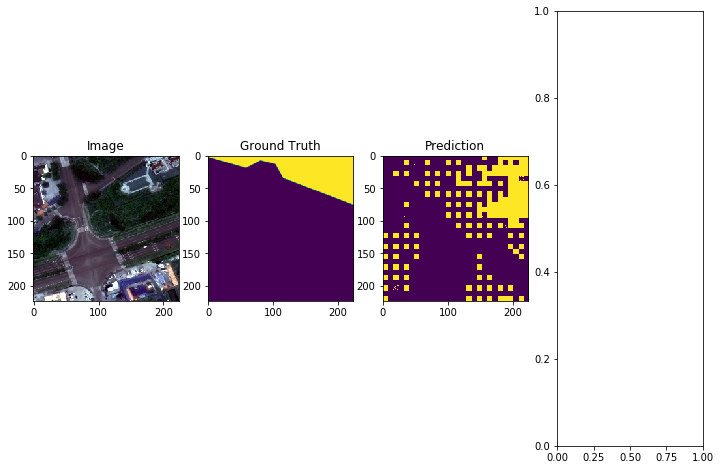

In [52]:
# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
# model = get_unet()
# model.load_weights('checkpoints/weights.50-0.08328.hdf5')

# Pick out which target to look at
CLASS_NO = 0

# Pick an image with some positive pixels in the target
usable_imgs = []
for i in range(Y_val.shape[0]):
    if Y_val[i, :, :, CLASS_NO].sum() > 5000:
        usable_imgs.append(i)
print("Found %d usable images in the validation set."%len(usable_imgs))
i = usable_imgs[21]
X = X_val[i]
Y = Y_val[i]

targ = Y[:, :, CLASS_NO]

# Run the model on that sample
pred = model.predict(X[None, ...])[0, :, :, CLASS_NO] > 0.05
# pred0 = model.predict(X[None, ...])[0, :, :, 0]
# pred1 = model.predict(X[None, ...])[0, :, :, 1]
# pred2 = model.predict(X[None, ...])[0, :, :, 2]
# pred3 = model.predict(X[None, ...])[0, :, :, 3]

# max0 = ((pred0 > np.maximum.reduce([pred1,pred2,pred3])) & (pred0 > 0.15)) * 1
# max1 = ((pred1 > np.maximum.reduce([pred0,pred2,pred3])) & (pred1 > 0.15)) * 2
# max2 = ((pred2 > np.maximum.reduce([pred0,pred1,pred3])) & (pred2 > 0.15)) * 3
# max3 = ((pred3 > np.maximum.reduce([pred0,pred1,pred2])) & (pred3 > 0.15)) * 4

# pred_new = np.maximum.reduce([max0, max1, max2, max3])

# print(np.sum(max0))
# print(np.sum(max1))
# print(np.sum(max2))
# print(np.sum(max3))

from matplotlib import colors

cmap = colors.ListedColormap(['k','b','y','g','r'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot it
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,8))
ax1.imshow(scale_bands(X[:, :, [2,1,0]])) # This index starts at 0, so I had to decrement
ax2.imshow(targ, vmin=0, vmax=1)
ax3.imshow(pred)

#ax4.imshow(pred_new, cmap=cmap)

ax1.set_title('Image')
ax2.set_title('Ground Truth')
ax3.set_title('Prediction')